# Smooth fit to log-odds ratios
**objective** : The objective of this study is to observe the influence/association between death from maternal exposure to X-rays and childhood cancer for subjects partitioned into 120 age and birth-year strata.



## 1. Data

Description : 
- $r^0_i$ : is the number of deaths among unexposed subjects in stratum $i$, 
- $n^0_i$ : is the total number of unexposed subjects in stratum $i$, 
- $r^1_i$ : is the number among exposed subjects in stratum $i$, 
- $n^1_i$ : is the total number of exposed subjects in stratum $i$
- $\text{year}_i$ : is the stratum-specific birth year (relative to 1954).

In [1]:
import numpy as np
import pandas as pd
from tqdm import trange
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("hls", 8)

np.random.seed(42)

In [2]:
r1 = np.asarray([3, 5, 2, 7, 7, 2, 5, 3, 5, 11, 6, 6, 11, 4, 4, 2, 8, 8, 6,  
               5, 15, 4, 9, 9, 4, 12, 8, 8, 6, 8, 12, 4, 7, 16, 12, 9, 4, 7, 
               8, 11, 5, 12, 8, 17, 9, 3, 2, 7, 6, 5, 11, 14, 13, 8, 6, 4, 8, 
               4, 8, 7, 15, 15, 9, 9, 5, 6, 3, 9, 12, 14, 16, 17, 8, 8, 9, 5, 
               9, 11, 6, 14, 21, 16, 6, 9, 8, 9, 8, 4, 11, 11, 6, 9, 4, 4, 9, 
               9, 10, 14, 6, 3, 4, 6, 10, 4, 3, 3, 10, 4, 10, 5, 4, 3, 13, 1, 
               7, 5, 7, 6, 3, 7])
n1 = np.asarray([28, 21, 32, 35, 35, 38, 30, 43, 49, 53, 31, 35, 46, 53, 61, 
               40, 29, 44, 52, 55, 61, 31, 48, 44, 42, 53, 56, 71, 43, 43, 43, 
               40, 44, 70, 75, 71, 37, 31, 42, 46, 47, 55, 63, 91, 43, 39, 35, 
               32, 53, 49, 75, 64, 69, 64, 49, 29, 40, 27, 48, 43, 61, 77, 55, 
               60, 46, 28, 33, 32, 46, 57, 56, 78, 58, 52, 31, 28, 46, 42, 45, 
               63, 71, 69, 43, 50, 31, 34, 54, 46, 58, 62, 52, 41, 34, 52, 63, 
               59, 88, 62, 47, 53, 57, 74, 68, 61, 45, 45, 62, 73, 53, 39, 45, 
               51, 55, 41, 53, 51, 42, 46, 54, 32])
r0 = np.asarray([0, 2, 2, 1, 2, 0, 1, 1, 1, 2, 4, 4, 2, 1, 7, 4, 3, 5, 3, 2, 
               4, 1, 4, 5, 2, 7, 5, 8, 2, 3, 5, 4, 1, 6, 5, 11, 5, 2, 5, 8, 
               5, 6, 6, 10, 7, 5, 5, 2, 8, 1, 13, 9, 11, 9, 4, 4, 8, 6, 8, 6, 
               8, 14, 6, 5, 5, 2, 4, 2, 9, 5, 6, 7, 5, 10, 3, 2, 1, 7, 9, 13, 
               9, 11, 4, 8, 2, 3, 7, 4, 7, 5, 6, 6, 5, 6, 9, 7, 7, 7, 4, 2, 
               3, 4, 10, 3, 4, 2, 10, 5, 4, 5, 4, 6, 5, 3, 2, 2, 4, 6, 4, 1])
n0 = np.asarray([28, 21, 32, 35, 35, 38, 30, 43, 49, 53, 31, 35, 46, 53, 61, 
               40, 29, 44, 52, 55, 61, 31, 48, 44, 42, 53, 56, 71, 43, 43, 43, 
               40, 44, 70, 75, 71, 37, 31, 42, 46, 47, 55, 63, 91, 43, 39, 35, 
               32, 53, 49, 75, 64, 69, 64, 49, 29, 40, 27, 48, 43, 61, 77, 55, 
               60, 46, 28, 33, 32, 46, 57, 56, 78, 58, 52, 31, 28, 46, 42, 45, 
               63, 71, 69, 43, 50, 31, 34, 54, 46, 58, 62, 52, 41, 34, 52, 63, 
               59, 88, 62, 47, 53, 57, 74, 68, 61, 45, 45, 62, 73, 53, 39, 45, 
               51, 55, 41, 53, 51, 42, 46, 54, 32])
year = np.asarray([-10, -9, -9, -8, -8, -8, -7, -7, -7, -7, -6, -6, -6, -6, -6, 
                 -5, -5, -5, -5, -5, -5, -4, -4, -4, -4, -4, -4, -4, -3, -3, -3, 
                 -3, -3, -3, -3, -3, -2, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, 
                 -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
                 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 
                 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 
                 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 9, 9, 10])

df = pd.DataFrame({'year': year,'n0': n0, 'n1': n1, 'r0': r0, 'r1':r1})
df.reset_index(drop=True, inplace=True)
df

,year,n0,n1,r0,r1
0,-10,28,28,0,3
1,-9,21,21,2,5
2,-9,32,32,2,2
3,-8,35,35,1,7
4,-8,35,35,2,7
...,...,...,...,...,...
115,8,51,51,2,5
116,8,42,42,4,7
117,9,46,46,6,6
118,9,54,54,4,3


# Model 

The proposed model [source](https://pj.freefaculty.org/Ubuntu/15.04/amd64/openbugs/openbugs-3.2.3/doc/Examples/Oxford.html) is as follows. $\forall i \text{ (stratum)} $

-   $r_i^0 \sim \text{Binomial}(n_i^0,p_i^0)$
-   $r_i^1 \sim \text{Binomial}(n_i^1,p_i^1)$.

The parameters $p_i^0$, $p_i^1$ are given by :

-   $p_i^0 = \text{sigmoid}(\mu_i)$
-   $p_i^1 = \text{sigmoid}(\mu_i+log\psi_i)$
    -   $\log\psi_i = \alpha+\beta_1 year_i+\beta_2(year_i^2-22)+b_i $
    -   $p_i^1 = \text{sigmoid}(\mu_i+\alpha+\beta_1 year_i+\beta_2(year_i^2-22)+b_i)$ 
- $ b_i \sim\mathcal N(0,1/\tau)$ ou $b_i \sim\mathcal N(0,\sigma^2)$

Then the non - informative laws are given by :
-  $\tau \sim\mathcal Gamma(10^{-3},10^{-3})$
-  $\sigma^2 \sim\mathcal InvGamma(10^{-3},10^{-3})$

-  $ \mu_i \sim\mathcal N(0,10^{6})$
-  $ \alpha \sim\mathcal N(0,10^{6})$
-  $ \beta_1 \sim\mathcal N(0,10^{6})$
-  $ \beta_2 \sim\mathcal N(0,10^{6})$

In [3]:
import numpy as np
from scipy.special import expit ## Better than manual implementation of sigmoid

def p0_f(mu):
    """
    Computes the probability that an unexposed individual is sick given the stratum-specific intercept mu,
    assuming a logistic regression model with a logit link function.
    
    Parameters:
    mu (float or numpy array): the stratum-specific intercept(s) of the logistic regression model.
    
    Returns:
    float or numpy array: the probability of a sick individual given the intercept mu, computed using the sigmoid function.
    """
    return expit(mu)

def p1_f(mu, alpha, beta1, beta2, b, year):
    """
    Computes the probability that an exposed individual is sick given the stratum-specific intercept mu,
    as well as the exposure-specific intercept alpha and slope parameters beta1 and beta2, the random effect b, 
    and the stratum-specific birth year year. Assumes a logistic regression model with a logit link function.
    
    Parameters:
    mu (float or numpy array): the stratum-specific intercept(s) of the logistic regression model.
    alpha (float): the exposure-specific intercept parameter of the logistic regression model.
    beta1 (float): the slope parameter of the logistic regression model for the birth year.
    beta2 (float): the second-order polynomial parameter of the logistic regression model for the birth year.
    b (float or numpy array): the random effect term(s) with a normal prior distribution.
    year (float or numpy array): the stratum-specific birth year(s) relative to 1954.
    
    Returns:
    float or numpy array: the probability of a sick individual given the logistic regression parameters and the random effect b, 
    computed using the sigmoid function.
    """
    return expit(mu + alpha + beta1*year + beta2*(year**2-22) + b)

def log_likelihood_r1(mu, alpha, beta1, beta2, b, r1, n1, year):
    """
    Computes the log-likelihood of the response variable for the exposed subjects in a stratum, given the stratum-specific intercept mu,
    as well as the exposure-specific intercept alpha and slope parameters beta1 and beta2, the random effect b, 
    the observed number of successes r1, the total number of trials n1, and the stratum-specific birth year year.
    Assumes a logistic regression model with a logit link function.
    
    Parameters:
    mu (float): the stratum-specific intercept of the logistic regression model.
    alpha (float): the exposure-specific intercept parameter of the logistic regression model.
    beta1 (float): the slope parameter of the logistic regression model for the birth year.
    beta2 (float): the second-order polynomial parameter of the logistic regression model for the birth year.
    b (float): the random effect term with a normal prior distribution.
    r1 (int): the number of successes (sick individuals) among the exposed subjects in the stratum.
    n1 (int): the total number of exposed subjects in the stratum.
    year (float): the stratum-specific birth year relative to 1954.
    
    Returns:
    float: the log-likelihood of the response variable for the exposed subjects in the stratum, given the logistic regression parameters 
    and the random effect b, computed using the sigmoid function.
    """
    p1 = p1_f(mu, alpha, beta1, beta2, b, year)
    r1 = np.sum(r1 * np.log(p1)) + sum((n1-r1) * np.log(1 - p1))
    return r1

In [4]:
def init_chain_1(N):
    """
     Proposed 1st initialisation by the authors of the paper    
    """
    alpha = 0
    beta1 = 0
    beta2 = 0
    sigma2 = 1
    mu = np.zeros(N)
    b = np.zeros(N)
    return alpha, beta1, beta2, sigma2, mu, b

def init_chain_2(N):
    """
     Proposed 2nd initialisation by the authors of the paper    
    """
    alpha = 1
    beta1 = 1
    beta2 = 1
    sigma2 = 10
    mu = np.zeros(N)
    b = np.zeros(N)
    return alpha, beta1, beta2, sigma2, mu, b

In [5]:

def gibbs(nchain: int, df: pd.DataFrame) -> Tuple[np.ndarray]:
    """
    This function performs Gibbs sampling to estimate the posterior distributions of the parameters alpha, beta1, beta2, sigma2, mu, and b
    for a given dataset.

    Args:
    - nchain (int): number of iterations to run the Gibbs sampler.
    - df (pandas.DataFrame): dataset containing the following columns:
        - 'r0': number of deaths among unexposed subjects in stratum i.
        - 'n0': total number of unexposed subjects in stratum i.
        - 'r1': number among exposed subjects in stratum i.
        - 'n1': total number of exposed subjects in stratum i.
        - 'year': stratum-specific birth year (relative to 1954).

    Returns:
    - chain_1 (numpy.ndarray): chain of alpha, beta1, beta2, sigma2
    - chain_2 (numpy.ndarray): chain of b
    - chain_3 (numpy.ndarray): chain of mu
    """

    # Number of Strata
    N=df.shape[0]

    # Initialization
    alpha, beta1, beta2, sigma2, mu, b = init_chain_1(N)
  
    # Chain of alpha, beta1, beta2, sigma2
    chain_1 = np.empty((nchain + 1, 4))

    # Chain of b 
    chain_2 = np.empty((nchain+1, N))

    # Chain of mu
    chain_3 = np.empty((nchain+1, N))

    # Begining of the chains : 
    chain_1[0,:] = alpha, beta1, beta2, sigma2
    chain_2[0,:] = b
    chain_3[0,:] = mu

    # p0 and p1
    p0 = p0_f(mu)
    p1 = p1_f(mu, alpha, beta1, beta2, b, year)    

    # Proposition of Standard deviations
    proposition_sd = [0.01, 0.01, 0.001, 0.5, 0.5]
    
    for iter in trange(1,nchain+1):

        # Random number for acceptance probability
        U =np.random.uniform()

        LVR = log_likelihood_r1(mu, alpha, beta1, beta2, b, r1, n1, year)

        # Updating Alpha
        prop = np.random.normal(loc = alpha, scale = proposition_sd[0])
        prop_p1 = p1_f(mu, prop, beta1, beta2, b, year)


        top = - (prop**2 / (2 * 1e6)) + sum(r1 * np.log(prop_p1)) + sum((n1-r1) * np.log(1 - prop_p1))
        bottom = - (alpha**2 / (2 * 1e6)) +LVR
        
        acc_prob = np.exp(top - bottom)
        
        if U  < acc_prob:
            alpha = prop
            p1 = prop_p1
        
        # Updating beta1
        prop = np.random.normal(loc = beta1, scale = proposition_sd[1])
        prop_p1 = p1_f(mu, alpha, prop, beta2, b, year)

        top = - (prop**2 / (2 * 1e6)) + sum(r1 * np.log(prop_p1)) + sum((n1-r1) * np.log(1 - prop_p1))
        bottom = - (beta1**2 / (2 * 1e6)) + LVR
        
        acc_prob = np.exp(top - bottom)
        
        if U < acc_prob:
            beta1 = prop
            p1 = prop_p1
            
        # Updating beta2
        prop = np.random.normal(loc = beta2, scale = proposition_sd[2])
        prop_p1 = p1_f(mu, alpha, beta1, prop, b, year)
        
        top = - (prop**2 / (2 * 1e6)) + sum(r1 * np.log(prop_p1)) + sum((n1-r1) * np.log(1 - prop_p1))
        bottom = - (beta2**2 / (2 * 1e6)) + LVR
        
        acc_prob = np.exp(top - bottom)
        
        if U < acc_prob:
            beta2 = prop
            p1 = prop_p1
            
        # Updating sigma2
        A =  1e-3 + N/2
        B =  1e-3 +(np.sum(b**2) /2)
        tau=np.random.gamma(shape =A, scale =B )
        sigma2 = 1/tau
            
        # Updating  mu
        for j in range(N):
            prop = np.random.normal(loc = mu[j], scale = proposition_sd[3])
            prop_p0_j=p0_f(prop)
            prop_p1_j=p1_f(prop, alpha, beta1, beta2, b[j], year[j])
            

            top = - (prop**2 / (2 * 1e6)) + r0[j] * np.log(prop_p0_j) + (n0[j] - r0[j]) * np.log(1 - prop_p0_j) + r1[j] * np.log(prop_p1_j) + (n1[j] - r1[j]) * np.log(1 - prop_p1_j)
            bottom = - (mu[j]**2 / (2 * 1e6)) + r0[j] * np.log(p0[j]) + (n0[j] - r0[j]) * np.log(1 - p0[j]) + r1[j] * np.log(p1[j]) + (n1[j] - r1[j]) * np.log(1 - p1[j])
            
            acc_prob = np.exp(top - bottom)
            
            if U < acc_prob:
                mu[j] = prop
                p0[j] = prop_p0_j
                p1[j] = prop_p1_j

        # Updating b
        for j in range(N):
            prop = np.random.normal(loc = b[j], scale = proposition_sd[4])
            prop_p1_j=p1_f(mu[j] , alpha, beta1, beta2, prop, year[j])

            top = - (prop**2 / (2 * sigma2)) + r1[j] * np.log(prop_p1_j) + (n1[j] - r1[j]) * np.log(1 - prop_p1_j)
            bottom = - (b[j]**2 / (2 * sigma2)) + r1[j] * np.log(p1[j]) + (n1[j] - r1[j]) * np.log(1 - p1[j])
            
            acc_prob = np.exp(top - bottom)
            
            if U < acc_prob:
                b[j] = prop
                p1[j] = prop_p1_j

        # Chain of alpha, beta1, beta2, sigma2
        chain_1[iter, :] = alpha, beta1, beta2,sigma2

        # Chain of b 
        chain_2[iter, :] = mu

        # Chain of mu
        chain_3[iter, :] = b


    return chain_1, chain_2, chain_3

In [6]:
chain_1, chain_2, chain_3 = gibbs(10**4, df)

100%|██████████| 10000/10000 [01:07<00:00, 147.88it/s]


# Results

We will remove the first 1000 iterations as we consider them as burn-in, then we will calculate the empiracle mean and standard deviation for each parameter. 

In [64]:
alpha = chain_1[1000:,0]
beta1 =  chain_1[1000:,1]
beta2 = chain_1[1000:,2]
sigma2 = chain_1[1000:,3]
sigma = np.sqrt(sigma2)

results = pd.DataFrame()
results['alpha']=alpha
results['beta1']=beta1
results['beta2']=beta2
results['sigma']=sigma
df = results.describe().T

df["mean_base"]=[0.579,-0.04557,0.007041, 0.09697]
df["std_base"]=[0.062, 0.01553, 0.003084, 0.06011]

def highlight_SLA(series):
    blue = 'background-color: lightblue' # Incide of IC
    pink = 'background-color: pink' # Outside of IC

    IC_alpha=[0.4587, 0.7037]
    IC_beta1=[ -0.07688, -0.01586]
    IC_beta2=[ 0.001, 0.01314]
    IC_sigma=[0.02419, 0.08059]
    
    lower=[IC_alpha[0], IC_beta1[0], IC_beta2[0], IC_sigma[0]]
    upper=[IC_alpha[1], IC_beta1[1], IC_beta2[1], IC_sigma[1]]
    return [pink if (value < lower[i] or value >upper[i]) else blue for i,value in zip(range(len(series)),series)]

df.drop(columns = ["count"], inplace=True)
cols = df.columns.tolist()
df = df [['mean', 'std','mean_base', 'std_base', 'min', '25%', '50%', '75%', 'max']]
df = df.style\
         .set_properties(**{'border': '0.5px solid black'}).bar(subset =  ["std", 'std_base'], 
             align = "mid", 
             color = ["salmon", "lightgreen"])\
          .apply(highlight_SLA, subset = ["mean", "mean_base"])
df

,mean,std,mean_base,std_base,min,25%,50%,75%,max
alpha,0.588951,0.063117,0.579000,0.062000,0.387552,0.548773,0.591383,0.631339,0.761930
beta1,-0.047544,0.014913,-0.045570,0.015530,-0.105919,-0.057299,-0.047606,-0.037402,0.004564
beta2,0.007364,0.002793,0.007041,0.003084,-0.002716,0.005649,0.007417,0.009211,0.018117
sigma,0.130891,0.021926,0.096970,0.060110,0.054730,0.116098,0.130598,0.145499,0.238036


We observe that our results are very similar to the baseline obtained results and all belong to their respective Confidence intervals.

## Visualisation.

In [9]:
def plot(variable, ax):
    """ Function to plot the Markov chain for a given variable.
    """
    sns.lineplot(
        data=results,
        x=results.index,
        y=variable,
        ax =ax,
    )

    # Add mean line
    mean = results[variable].mean()
    std = results[variable].std()
    ax.axhline(y=mean, color="r", linestyle="--", label="Mean")
    ax.axhline(y=mean+std, color="b", linestyle="--", label="+std", alpha = 0.5)
    ax.axhline(y=mean-std, color="b", linestyle="--", label="-std", alpha = 0.5)

    ax.fill_between(results.index, mean-std, mean+std, alpha=0.2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


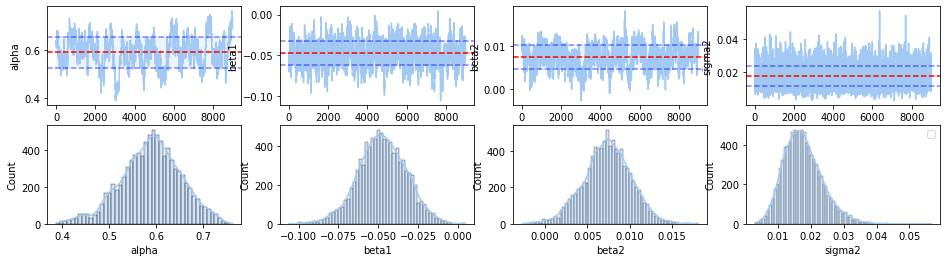

In [10]:
sns.set_palette("pastel")

fig, axs = plt.subplots(2,4)
fig.set_size_inches(16,4)

for i, variable in enumerate(results.columns):

    plot(variable, axs[0][i] )
    sns.histplot(results, x=variable, kde="True", fill=True,ax=axs[1][i])

plt.legend()
plt.show()

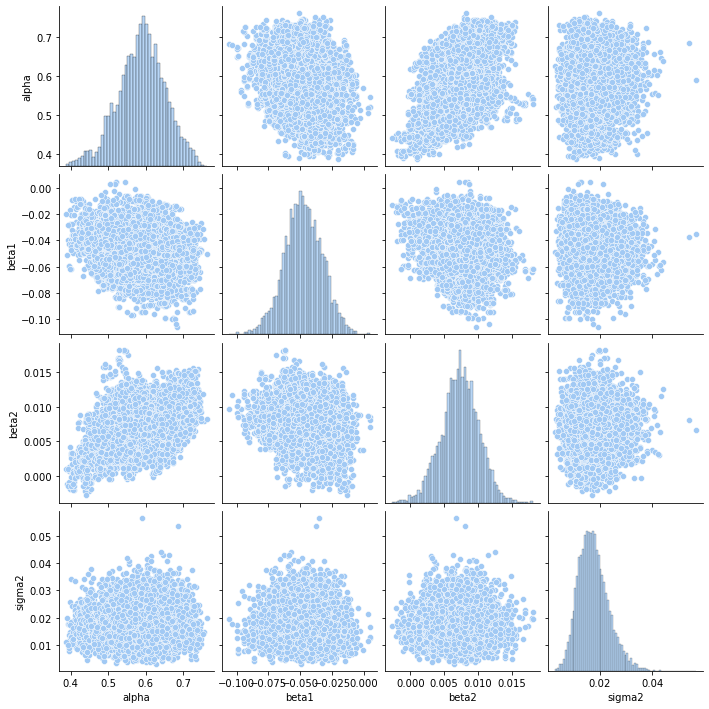

In [11]:
sns.pairplot(results)

The first row of the first figure illustrate the evolution of the Markov chain associated with the parameters $\alpha, \beta _1, \beta _2, \sigma ^2$, at each step. The second row displays the density of the probability distribution of the values of the above parameters at the end of the Markov chain.
The empirical means and empirical standard deviations of the estimated coefficients suggest that the obtained results are in line with the expected theoretical results for the Bayesian estimation of these coefficients.
The second figure is a grid of scatter plots that displays the relationships between pairs of our parameters. Each scatter plot in the grid shows the correlation between two different parameters, while the diagonal of the grid shows the distribution of each parameter.

# Results' interpretation and conclusion

Text(0.5, 0, 'year')

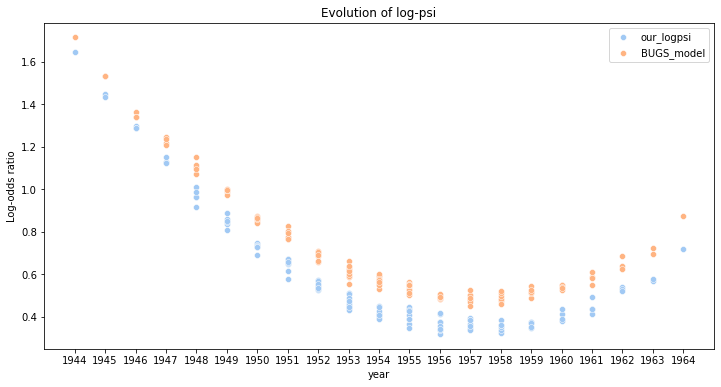

In [12]:
our_logpsi = results["alpha"].mean() + results["beta1"].mean() * year + results["beta2"].mean() * (year**2 - 22) + np.mean(chain_3,axis=0)
Breslow_and_Clayton= 0.566 +  (-0.469*year) + 0.0071* (year**2-2) +  np.mean(chain_3,axis=0)
bugs_b=np.random.normal(0, 0.15**2, 120)
BUGS_model =0.579 +  (-0.04557 *year) + 0.007041 * (year**2-2) +bugs_b
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

x_axis = [str(i+1954) for i in year]

ax = sns.scatterplot(
    x=x_axis,
    y=our_logpsi,
    label="our_logpsi",
)

ax = sns.scatterplot(
    x=x_axis,
    y=BUGS_model,
    label="BUGS_model",
)
plt.title("Evolution of log-psi")
plt.ylabel('Log-odds ratio')
plt.xlabel('year')



Upon examining the past figure we can observe the similarity between both our model and the one obtained from the source document, we can also observe a decrease in the value of log(Ψ) for both models as the year of birth increases, particularly between the years 1944 and 1959 where until reaches its minimum at around 1956 and 1959. This decline suggests a reduction in the risk difference between exposed healthy subjects and exposed diseased subjects. As a result, it can be asserted that in the early years, exposure to X-rays indeed elevated the risk of childhood cancer.

However, following the year 1959 until 1964, we notice a slight increase in log(Ψ). Unfortunately, we lack sufficient information to evaluate its long-term evolution. Consequently, it is challenging to determine whether the risk of cancer due to X-ray exposure is once again on the rise over the years.

It is essential to conduct further research and collect more data to better understand the relationship between X-ray exposure and cancer risk in the context of changing technology, safety standards, and healthcare practices. This additional information will help us determine if the observed increase in log(Ψ) is a temporary fluctuation or indicative of a more persistent trend in cancer risk associated with X-ray exposure.